# Customer Sentiment Analysis for an e-Commerce retailer

In this project I will use data from the reviews given by the customers to predict the sentiment of the customers towards the retailer and classify the customers as positive, negative or neutral customers.

Because this is real commercial data, it has been anonymized, and references to the company in the review text and body have been replaced with "retailer".

The data is part of the Sample Cases available at [Analyttica Datalab](https://leapsapp.analyttica.com/cases/2983)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud
import matplotlib.style as style
style.use('fivethirtyeight')

pd.set_option('max_colwidth', 65)

/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
data = pd.read_csv('/content/drive/MyDrive/Proyectos DS/Customer sentiment analysis on e-commerce/Womens_Clothing_ECommerce_Reviews.csv',
                   sep=';')
display(data.head())
display(data.shape)

,id,Clothing_ID,Age,Title,Review_Text,Rating,Recommended_IND,Positive_Feedback_Count,Division_Name,Department_Name,Class_Name
0,0,767,33,NaN,Absolutely wonderful - silky and sexy and comfortable,4,1,0,Initmates,Intimate,Intimates
1,1,1080,34,NaN,Love this dress! it's sooo pretty. i happened to find it in...,5,1,4,General,Dresses,Dresses
2,2,1077,60,Some major design flaws,I had such high hopes for this dress and really wanted it to ...,3,0,0,General,Dresses,Dresses
3,3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, flirty, and fabul...",5,1,0,General Petite,Bottoms,Pants
4,4,847,47,Flattering shirt,This shirt is very flattering to all due to the adjustable fr...,5,1,6,General,Tops,Blouses


(23486, 11)

The data contain 23,486 rows of data and 11 columns which 10 of them can be considered as features. Each row corresponds to a customer review and includes the variables:

|Variable|Description|
|:------:|:---------:|
|id|Serial No.|
|Clothing_ID|Integer Categorical variable that refers to the specific piece being reviewed|
|Age|Positive Integer variable of the reviewers age|
|Title|String variable for the title of the review|
|Review Text|String variable for the review body|
|Rating|Positive Ordinal Integer variable for the product score granted by the customer, from 1 (worst) to 5 Best|
|Recomended_IDN|Binary variable stating where the customer recommends the product where 1 recommended, 0 is not recommended|
|Positive_Feedback_Count|Positive integer documenting the number of other customers who found this review positive|
|Division_Name|Categorical name of the product high-level division|
|Department_Name|Categorical name of the product department name|
|Class_Name|Categorical name of the product class name|

## Cleaning Data

In [3]:
data.isnull().sum()

id                            0
Clothing_ID                   0
Age                           0
Title                      3810
Review_Text                 845
Rating                        0
Recommended_IND               0
Positive_Feedback_Count       0
Division_Name                14
Department_Name              14
Class_Name                   14
dtype: int64

There are 845 rows with missing data in the Review_Text column, as this is the column that we will use to make the analysis we could drop those rows as they represent less than 5% of the data. The rows of the Title column represent 16% of the data, but we are not going to use them in the analysis so we can leave them as we only use the Review_Text column

In [4]:
data.dropna(subset=['Review_Text'], inplace=True)
display(data.isnull().sum())
data.reset_index(drop=True, inplace=True)
display(data.shape)

id                            0
Clothing_ID                   0
Age                           0
Title                      2966
Review_Text                   0
Rating                        0
Recommended_IND               0
Positive_Feedback_Count       0
Division_Name                13
Department_Name              13
Class_Name                   13
dtype: int64

(22641, 11)

## Data Exploration

Text(0.5, 1.0, 'Rating Histogram')

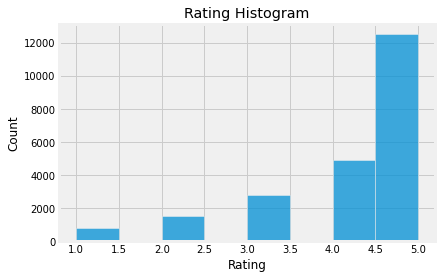

In [5]:
sns.histplot(data=data, x='Rating', bins=8)
plt.title('Rating Histogram')

From the 23,000 rows of data, over 16,000 of them are reviews that receive a rating over between 4.0 and 5.0. Which tell us that most of the reviews are positive. There are almost 3,000 reviews with a rating between 3.0 and 3.5 which can be assumed as neutral and finally there are about 2,500 rows with negative reviews

Text(0, 0.5, '')

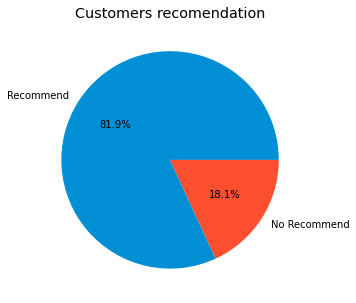

In [6]:
fig = plt.figure(figsize=(10,5))
data['Recommended_IND'].value_counts().plot(kind='pie', labels=['Recommend', 'No Recommend'], autopct='%1.1f%%')
plt.title('Customers recomendation')
plt.ylabel('')

In general, 81.9% of the customers will recommend their purchase while 18.1% doesn't recommend their purchase. This goes according to the histogram as the 17,000 reviews with ratings between 4.0 and 5.0 represent 73.9% of the reviews. So we can assume that customers with neutral reviews are also recommending their purchase.

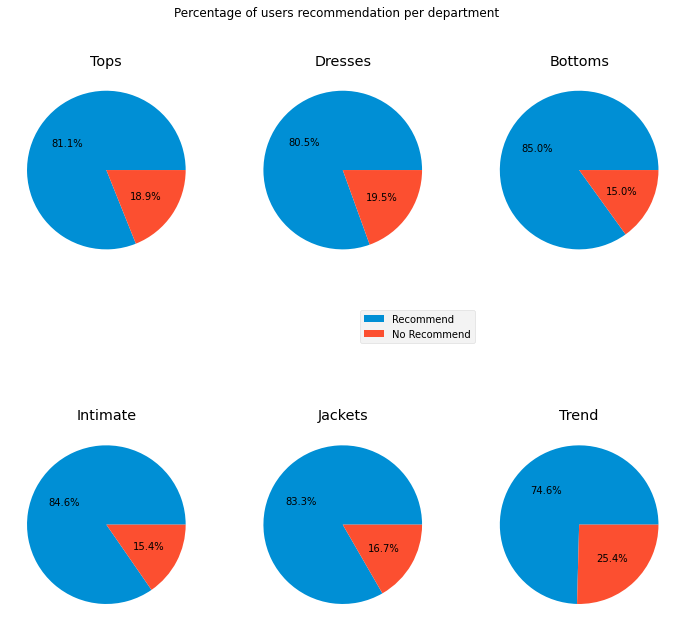

In [7]:
fig, ax = plt.subplots(2, 3, figsize=(10,10))
ax = ax.flatten()
fig.tight_layout()
departments = ['Tops', 'Dresses', 'Bottoms', 'Intimate', 'Jackets', 'Trend']

i = 0
for department in departments:
  dept_data = data[data['Department_Name'] == department]
  counts = dept_data['Recommended_IND'].value_counts()
  ax[i].pie(counts, autopct='%1.1f%%', labels=None)
  ax[i].set_title(department)
  i += 1
  
plt.suptitle('Percentage of users recommendation per department')
plt.legend(['Recommend', 'No Recommend'], loc='right', bbox_to_anchor=(-0.5, 1, 0.5, 1))

The department with most recommendations is Bottoms with 85.%, Trend is the department with least recommendation with 74.6%. So let's see the ratings at the Trend Department.

Average rating at Trend department: 3.84


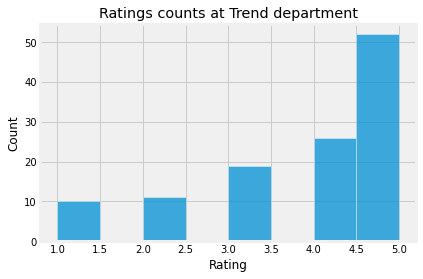

In [8]:
trend = data[data['Department_Name'] == 'Trend']
sns.histplot(data=trend, x='Rating', bins=8)
plt.title('Ratings counts at Trend department')
print('Average rating at Trend department: {:.3}'.format(trend['Rating'].mean()))

The Trend Department have an average rating of 3.84, and it looks like most of the reviews are neutral and negative. So this department needs to get a profound analysis.

## Sentiment Analysis



After doing a little exploration, and finding that we need to focus on the Trend Department, we proceed to preprocess the data and build the corpus to apply the sentiment analysis. In this project we will use VADER model to do the analysis. This model was made for social media sentiment analysis, but it also has good results with product reviews with an overall precision of 0.76 as it was reported on: **Hutto, C.J. & Gilbert, E.E. (2014). VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text. Eighth International Conference on Weblogs and Social Media (ICWSM-14). Ann Arbor, MI, June 2014**.

We decided to use VADER as it performs better than other models and it doesn't need preprocessed text as removing Stopwords and Lemmatization are not necessary in most cases, as is shown [here](https://medium.com/data-science-blogs/stopwords-and-lexicon-normalization-for-sentiment-analysis-f9f10f0d4108)

In [9]:
import nltk
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [10]:
sw = stopwords.words('english')
data['corpus'] = data['Review_Text'].apply(lambda x: " ".join(x for x in x.split() if x not in sw))

clf = SentimentIntensityAnalyzer()
polarity_scores = []
sentiments = []
for sentence in data['corpus']:
  sentiment = clf.polarity_scores(sentence)
  polarity_scores.append(sentiment)
  if (sentiment['neg'] > 0) and (sentiment['neu'] < 0.75) or (sentiment['compound'] < 0):
    sentiments.append('Negative')
  elif sentiment['pos'] >= 0.2:
    sentiments.append('Positive')
  else:
    sentiments.append('Neutral')
  output = {'Polarity_Score':polarity_scores, 'Sentiment':sentiments}
  output_df = pd.DataFrame.from_dict(output)

data = pd.concat([data, output_df], axis=1)
data[['Review_Text', 'Polarity_Score', 'Sentiment']].head()

,Review_Text,Polarity_Score,Sentiment
0,Absolutely wonderful - silky and sexy and comfortable,"{'neg': 0.0, 'neu': 0.154, 'pos': 0.846, 'compound': 0.8991}",Positive
1,Love this dress! it's sooo pretty. i happened to find it in...,"{'neg': 0.0, 'neu': 0.521, 'pos': 0.479, 'compound': 0.972}",Positive
2,I had such high hopes for this dress and really wanted it to ...,"{'neg': 0.036, 'neu': 0.705, 'pos': 0.259, 'compound': 0.9117}",Negative
3,"I love, love, love this jumpsuit. it's fun, flirty, and fabul...","{'neg': 0.163, 'neu': 0.206, 'pos': 0.631, 'compound': 0.9511}",Negative
4,This shirt is very flattering to all due to the adjustable fr...,"{'neg': 0.0, 'neu': 0.497, 'pos': 0.503, 'compound': 0.9213}",Positive


Text(0.5, 0.98, 'Sentiment Distribution')

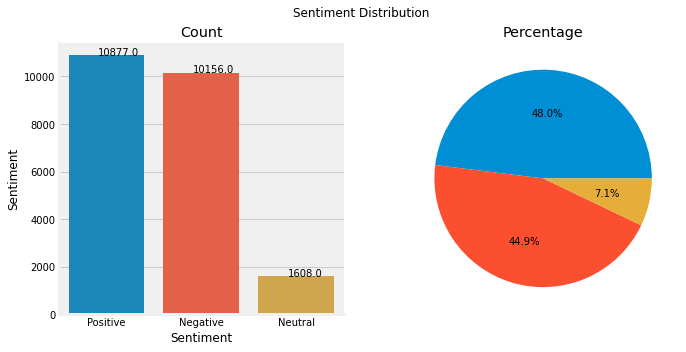

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax = ax.flatten()

sentiment_counts = data['Sentiment'].value_counts()

sns.barplot(ax=ax[0], x=sentiment_counts.index, y=sentiment_counts, ci=None)
ax[0].set_title('Count')
ax[0].set_xlabel('Sentiment')
sns.despine(left=False, bottom=False)
x_offset = -0.09
y_offset = 0.5
for p in ax[0].patches:
    b = p.get_bbox()
    val = "{}".format(b.y1 + b.y0)        
    ax[0].annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

ax[1].pie(sentiment_counts, autopct='%1.1f%%')
ax[1].set_ylabel('')
ax[1].set_title('Percentage')

plt.suptitle('Sentiment Distribution')

After the sentiment Analysis we found that 10,877 (48.0%) of the reviews are classified as positive, 10,156 (44.9%) are classified as negative and only 1,608 (7.1%) are neutral. Before we found that the Trend Department is the department with least recommendation. Let's see how many positive, negative and neutral reviews each department have.

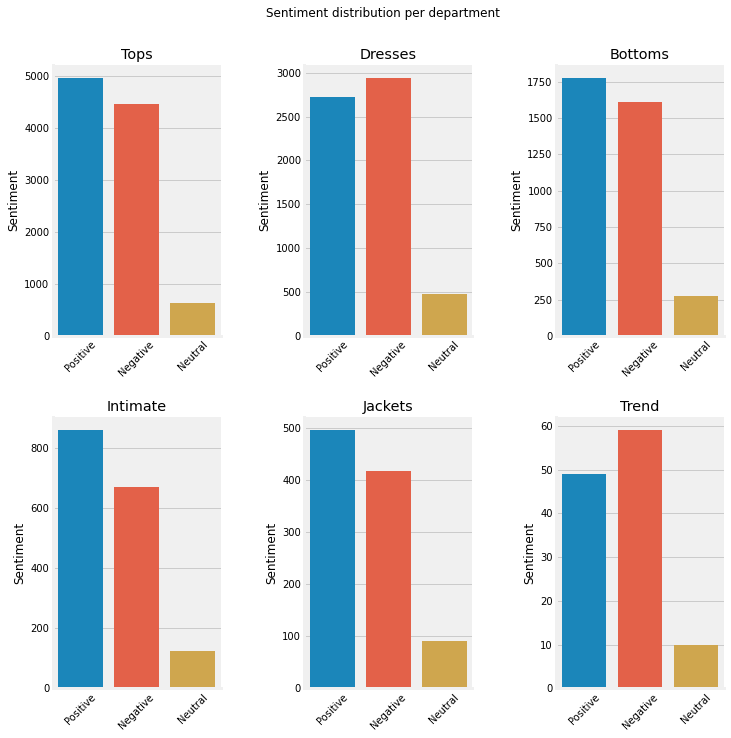

In [12]:
fig, ax = plt.subplots(2, 3, figsize=(10,10))
ax = ax.flatten()
fig.tight_layout()
fig.subplots_adjust(top=0.9, wspace=0.5, hspace=0.9)

departments = ['Tops', 'Dresses', 'Bottoms', 'Intimate', 'Jackets', 'Trend']

i = 0
for department in departments:
  dept_data = data[data['Department_Name'] == department]
  counts = dept_data['Sentiment'].value_counts()
  sns.barplot(ax=ax[i], x=counts.index, y=counts, order=['Positive', 'Negative', 'Neutral'])
  ax[i].set_title(department)
  sns.despine(left=False, bottom=False)
  ax[i].tick_params(axis='x', rotation=45)
  i += 1
  
plt.suptitle('Sentiment distribution per department')
plt.subplots_adjust(hspace=0.3)


In the Tops and Bottoms departments, Positive and Negative categories are close. The Intimate and Jackets departments have an interest difference between those categories. It's interesting that at Trend and Dresses departments Negative sentiment is higher than Positive sentiment, it is also interesting that these two categories have high recommendation values with 80.5% and 74.6% respectively. This could have happened because VADER has a score for each word and the model kind of summarizes the scores, so in a review there might been a word with high negative value that can affect the end value of the review. Also, it's necessary to remember that even if VADER it's the best model to use, not only because it's easy to apply but also because it's the model with the greatest precision in the products review category (0.76) and it's only surpassed by human classification.

## Word clouds

We already found the sentiment category for each review, now let's see wich words are used in each category (Positive, Negative, Neutral) and in Dresses and Trend departments.

### General Word Cloud

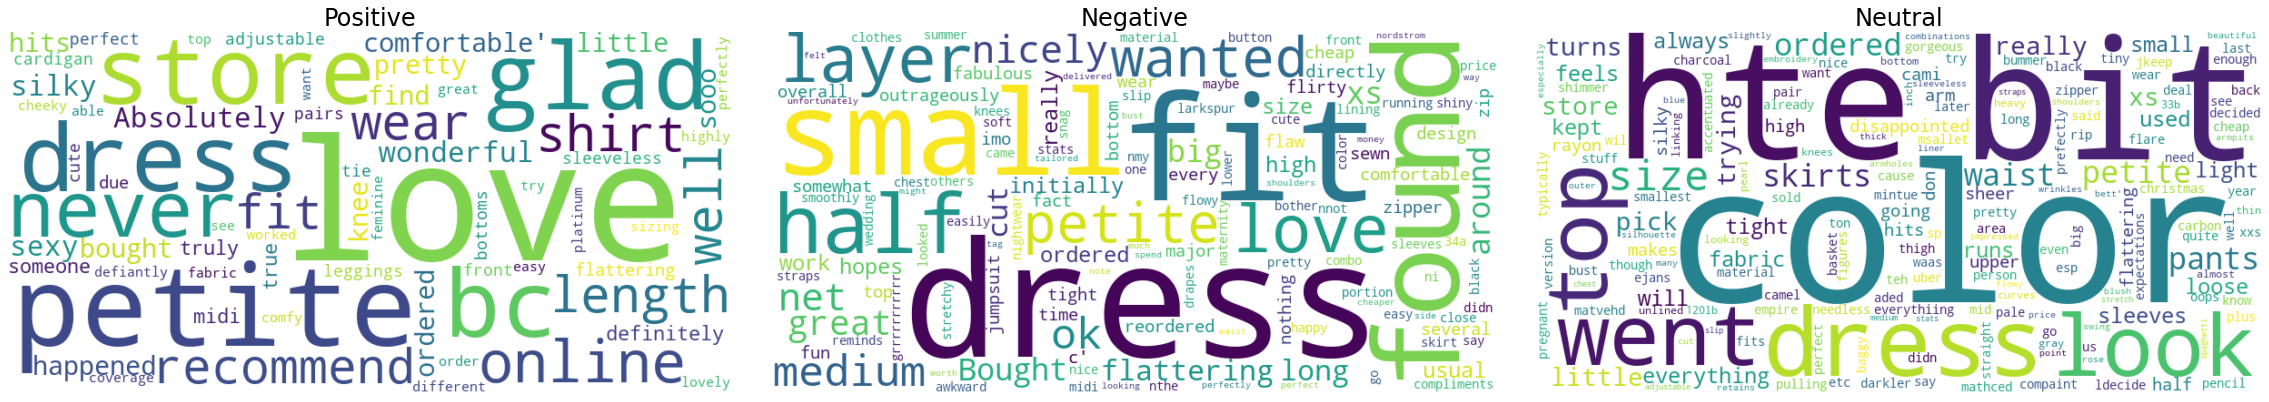

In [13]:
def plot_wordclouds(df):
  '''This function makes a cloud word for each sentiment
  on a plot with 1 row and 3 columns
  df = dataframe to plot'''
  fig, ax = plt.subplots(1, 3, figsize=(32,16))
  fig.tight_layout()

  sentiments = ['Positive', 'Negative', 'Neutral']
  i = 1
  for sentiment in sentiments:
    ax = plt.subplot(1, 3, i)
    sentiment_data = df[df['Sentiment'] == sentiment]
    text = sentiment_data['Review_Text'].values
    cloud = WordCloud(width=800, height=400, background_color='white').generate(str(text))
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(sentiment, fontsize=24)
    i += 1

plot_wordclouds(data)

These word clouds show the frequency of the words in each sentiment in all the data. The most used words at the Positive cloud are Petite, Love, Store, Dress, Glad, Never and Online. We also find interesting words like wonderful, perfectly, lovely. We can infer that customers who wrote a positive comment are satisfied with the product that they bought. There's mention of the fabric, so they are also happy with the quality of the product.

On the Negative cloud, we found that there is a lot of problems with the sizes (petite, Small, Medium, XS). Customers also aren't satisfied with the fit and comfort of the products, and apparently they also found the same product with cheaper prices somewhere else.

The Neutral side shows that customers aren't 100% happy or unhappy with their purchase but at the same time they feel that the product might be better. Things like Color, sizes, materials and fit are things that the stores need to improve.

### Word Clouds for Dresses Department

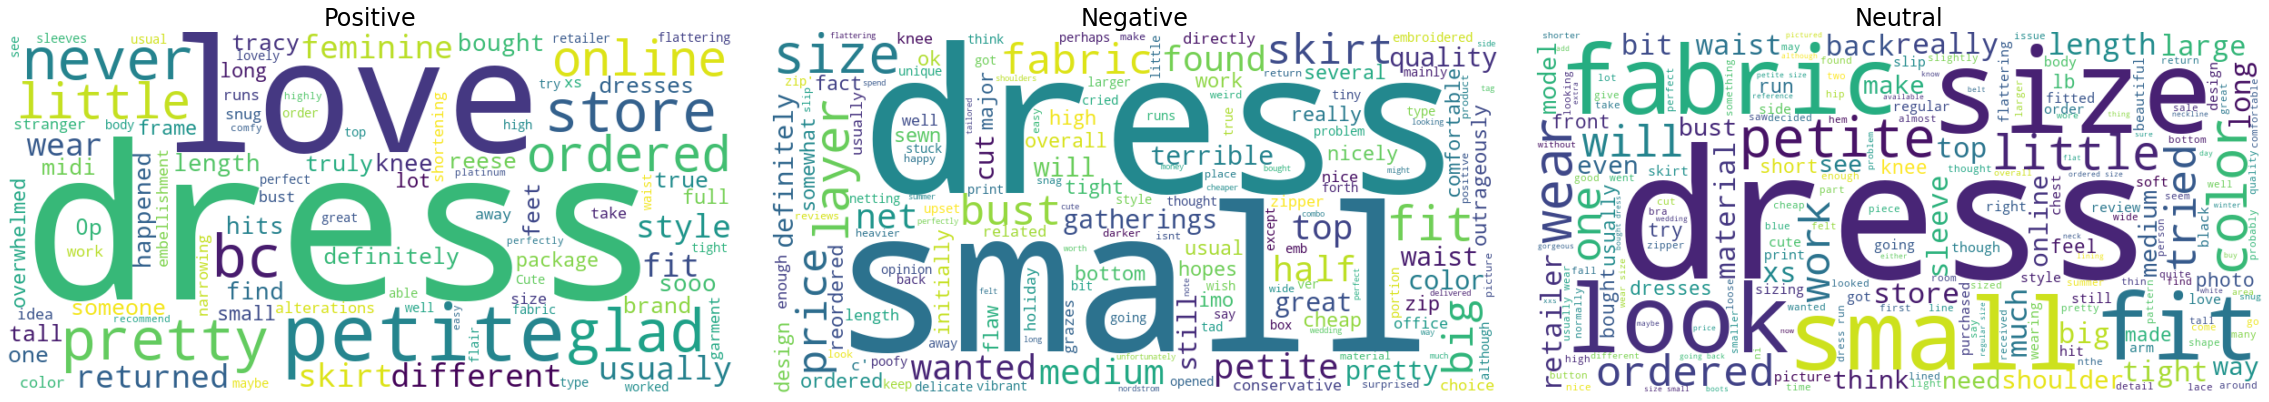

In [14]:
dresses = data[data['Department_Name'] == 'Dresses']
plot_wordclouds(dresses)

On the Dresses Department, we found that on the positive side customers are satisfied with the dress, sizes, beauty and material. It also looks like they are satisfied with the return service. The word recommend have a small frequency, so it looks like not every customer recommends the products of this department.

The Negative side shows us the different problems that customers have, apparently the biggest issue is with sizes and fits, they also complain about materials, prices and colors. The quality of the dresses is also a problem.

Neutral comments show us that customers think that things like quality, sizes, color, materials and the service could be better.

### Word Clouds for Trend Department

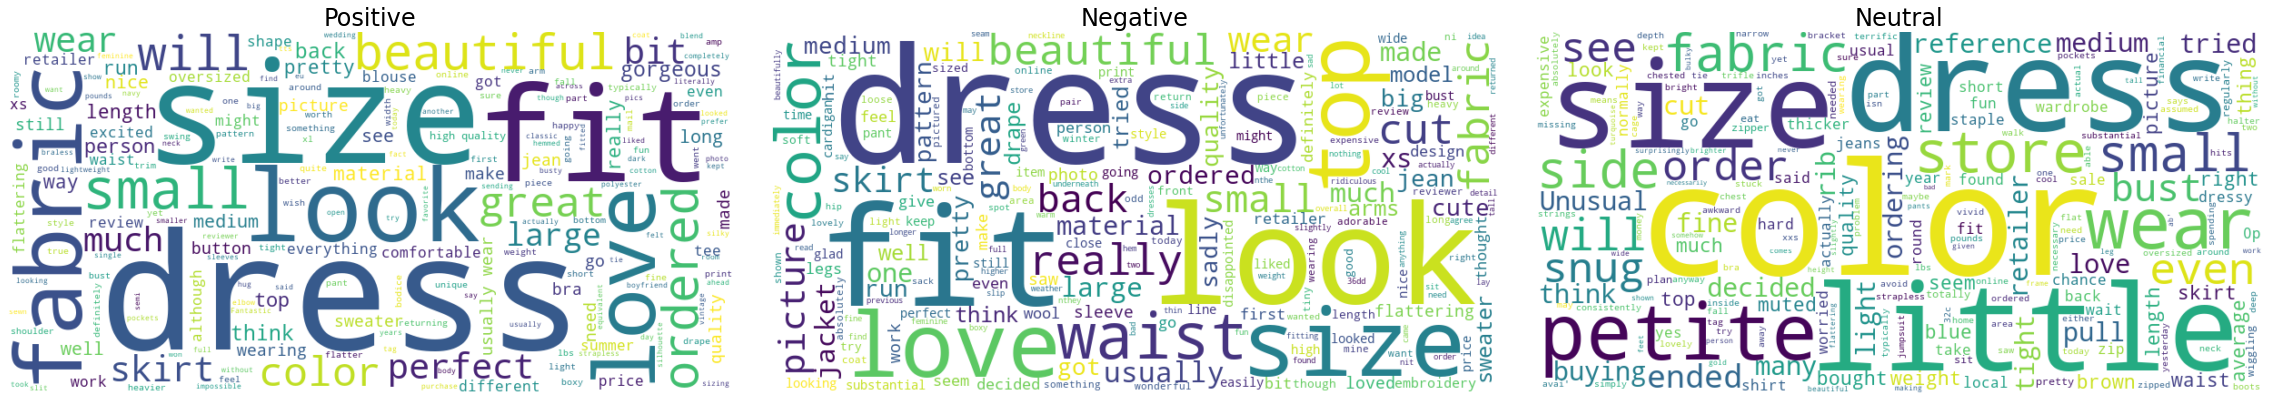

In [15]:
trend = data[data['Department_Name'] == 'Trend']
plot_wordclouds(trend)

On the Trend Department we found similar words than the Dresses Department.

The positive cloud shows us that some customers are happy with the sizes, designs and materials. It also looks like the products brought are comfortable.

But at the same time, some customers are also complaining about Sizes, fitting, materials, products. The words picture, ordered and different make us assume that some customers complained about seeing different products on the image description than the ones they got.

And just like the Dresses Department we can assume that customers wants improvements at products, sizes, colors, fitting and materials.

## Conclusion

We used VADER to find the sentiment of different reviews for an e-commerce company. First we found that most of the departments are recommended, but the Trend Department has only a 75% of user recommendations. The sentiment analysis showed that the store, in general, had positive comments (48%) , but we found that at least 44.9% of the comments are negative. A profound analysis showed that the Dresses and Trend Department had more negative comments than the other departments.

The word clouds showed us that most complained are about sizes, product quality, materials, prices and a possible false advertising. We also found that some portion of the users are neutral and it looks like they feel that the store can have improvements.